In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.utils import resample
from bootstrapped import bootstrap as bs
from bootstrapped import stats_functions as bs_stats
from joblib import Parallel, delayed

Data can be downloaded separately: todo: datalad link
Downloaded data is assumed to be in the data directory.

In [21]:
# Load data
data = pd.read_csv("../data/signatures.csv")
studies = pd.read_csv("../data/palm/simple_zerocon/df_studies.csv")

# Exclude studies with insufficient data
exclude_studies = ["kessner", "ruetgen", "wager04a_princeton", "wager04b_michigan"]
studies = studies[~studies['study_ID'].isin(exclude_studies)]

data['plc_induction'] = data['Conditioning'].astype('category').cat.codes
data['Rating_diff'] = -1*data['Rating_diff']   # higher score stronger placebo
# center explanatory variables
data['Rating_pain_ctr'] = data['Rating_pain_ctr'] - data['Rating_pain_ctr'].mean()
data['Age'] = data['Age'] - data['Age'].mean()
data['Male'] = data['Male'] - data['Male'].mean()

# Display column names (optional)
# print(data.columns)
# print(studies.columns)

### Display the data to get an overview of the dataset

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_65973/1676356102.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.006896551724137931' has dtype incompatible with int8, please explicitly cast to a compatible dtype first.
  pheno.loc[pheno['plc_induction'] == 0, 'plc_induction'] = -1 / (pheno['plc_induction'] == 0).sum()
/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_65973/1676356102.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"]

plc_induction   -1.389815e-16
study_0         -8.686342e-18
study_5         -1.737268e-17
study_6         -3.474537e-17
study_12         5.211805e-17
study_13         0.000000e+00
study_1         -3.474537e-17
study_2          6.949073e-17
study_3          5.211805e-17
study_4          8.686342e-17
study_7          1.737268e-17
study_8          5.211805e-17
study_9          3.474537e-17
study_10        -6.080439e-17
study_11        -2.605902e-17
study_14         3.474537e-17
study_15         3.474537e-17
dtype: float64

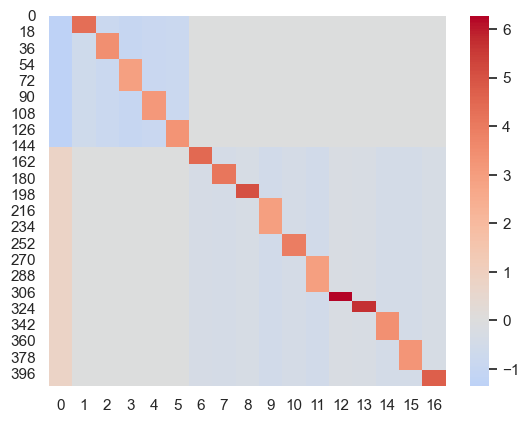

In [22]:
# create regression coded covariates for studies, being orthogonal to the "plc_induction" variable
# we do "simple coding", i.e. all regressors sum up to zero

def simple_coding(orig_pheno, sort=False):
    pheno = orig_pheno.copy()
    pheno['plc_induction'] = pheno['Conditioning'].astype('category').cat.codes
    # sort dataframe by induction type
    if sort:
        pheno = pheno.sort_values(by=['plc_induction', 'Study_ID'], inplace=False)

    # first we set 0 to -1 in induction type
    pheno.loc[pheno['plc_induction'] == 0, 'plc_induction'] = -1 / (pheno['plc_induction'] == 0).sum()
    pheno.loc[pheno['plc_induction'] == 1, 'plc_induction'] = 1 / (pheno['plc_induction'] == 1).sum()
    # model studies
    pheno['study'] = pheno['Study_ID'].astype('category').cat.codes
    # create simple coded variables
    colnames = []
    for i in pheno['study'].unique():
        colnames.append(f'study_{i}')
        pheno[f'study_{i}'] = 0
        # which induction type does this study belong to
        induction_type = pheno.loc[pheno['study'] == i, 'plc_induction'].unique()[0]
        # number of participants in the study
        n_instudy = pheno.loc[pheno['study'] == i].shape[0]
        # number of participants not in the study, but being in the same induction type
        n_notinstudy_ind = pheno.loc[(pheno['study'] != i) & (pheno['plc_induction'] == induction_type)].shape[0]
        pheno[f'study_{i}'].loc[pheno['plc_induction'] == induction_type] = -1 / n_notinstudy_ind
        pheno[f'study_{i}'].loc[pheno['study'] == i] = 1 / n_instudy
    return pheno, colnames


# plot the design matrix
design_sorted, colnames = simple_coding(data, sort=True)
design_sorted = design_sorted[['plc_induction'] + colnames]
design_sorted /= design_sorted.std()
sns.heatmap(design_sorted.to_numpy(), cmap='coolwarm', center=0)
# column means
design_sorted.mean()

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_65973/1676356102.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.006896551724137931' has dtype incompatible with int8, please explicitly cast to a compatible dtype first.
  pheno.loc[pheno['plc_induction'] == 0, 'plc_induction'] = -1 / (pheno['plc_induction'] == 0).sum()
/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_65973/1676356102.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"]

plc_induction   -4.343171e-17
study_0          0.000000e+00
study_1         -1.042361e-16
study_2          6.949073e-17
study_3          1.737268e-17
study_4          3.474537e-17
study_5         -1.042361e-16
study_6         -6.949073e-17
study_7         -3.474537e-17
study_8          6.949073e-17
study_9          3.474537e-17
study_10        -2.605902e-17
study_11        -1.737268e-17
study_12         3.474537e-17
study_13         0.000000e+00
study_14        -5.211805e-17
study_15         3.474537e-17
dtype: float64

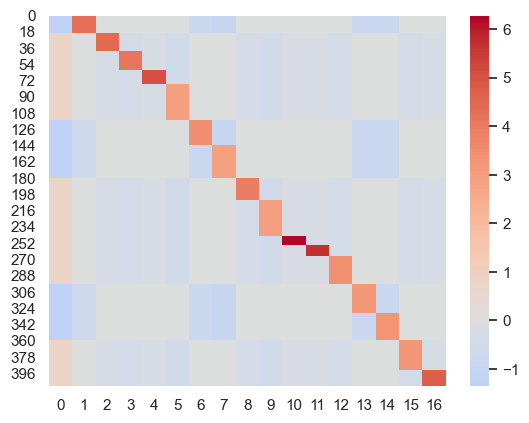

In [23]:
# The previous one was sorted for visualization purposes, here's the one to be used for the analyses
# plot the design matrix
design, colnames = simple_coding(data, sort=False)
design[['plc_induction'] + colnames] /= design[['plc_induction'] + colnames].std()
sns.heatmap(design[['plc_induction'] + colnames].to_numpy(), cmap='coolwarm', center=0)
# column means
design[['plc_induction'] + colnames].mean()

### Analysis of the placebo induction effect on the rating difference.
We will calculate the mean rating difference for the "suggestions" and "suggestions & conditioning" groups.
Then, we will compute the difference between these two means.


In [24]:
mean_inst = data[data['Conditioning'] == "suggestions"]['Rating_diff'].mean()
mean_cond = data[data['Conditioning'] == "suggestions & conditioning"]['Rating_diff'].mean()

print(f'Mean (INST): {mean_inst}')
print(f'Mean (COND-INST): {mean_cond}')
print(f'Difference: {mean_cond - mean_inst}')

Mean (INST): 9.17965372196802
Mean (COND-INST): 12.225893552576416
Difference: 3.046239830608396


In [25]:
import statsmodels.formula.api as smf
# Adding interaction term directly in the formula
formula = 'Rating_diff ~ plc_induction + Rating_pain_ctr + Age + Male' + ' + ' + ' + '.join(colnames)
print(formula)
# Fit linear model using formula API
model = smf.ols(formula=formula, data=design).fit()
print(model.summary())

print('One tailed p-value for plc_induction:', np.round(model.pvalues['plc_induction']/2, 3))

Rating_diff ~ plc_induction + Rating_pain_ctr + Age + Male + study_0 + study_1 + study_2 + study_3 + study_4 + study_5 + study_6 + study_7 + study_8 + study_9 + study_10 + study_11 + study_12 + study_13 + study_14 + study_15
                            OLS Regression Results                            
Dep. Variable:            Rating_diff   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     4.853
Date:                Mon, 20 Jan 2025   Prob (F-statistic):           7.29e-10
Time:                        11:25:37   Log-Likelihood:                -1695.8
No. Observations:                 409   AIC:                             3430.
Df Residuals:                     390   BIC:                             3506.
Df Model:                          18                                         
Covariance Type:            nonrobust                           

In [26]:
import statsmodels.formula.api as smf
# Adding interaction term directly in the formula
formula = 'Rating_diff ~ plc_induction * Rating_pain_ctr + Age + Male' + ' + ' + ' + '.join(colnames)
print(formula)
# Fit linear model using formula API
model = smf.ols(formula=formula, data=design).fit()
print(model.summary())

print('One tailed p-value for plc_induction:', np.round(model.pvalues['plc_induction']/2, 3))

Rating_diff ~ plc_induction * Rating_pain_ctr + Age + Male + study_0 + study_1 + study_2 + study_3 + study_4 + study_5 + study_6 + study_7 + study_8 + study_9 + study_10 + study_11 + study_12 + study_13 + study_14 + study_15
                            OLS Regression Results                            
Dep. Variable:            Rating_diff   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     4.751
Date:                Mon, 20 Jan 2025   Prob (F-statistic):           5.84e-10
Time:                        11:25:38   Log-Likelihood:                -1694.5
No. Observations:                 409   AIC:                             3429.
Df Residuals:                     389   BIC:                             3509.
Df Model:                          19                                         
Covariance Type:            nonrobust                           

In [27]:
import statsmodels.formula.api as smf
# Adding interaction term directly in the formula
formula = 'Rating_diff ~ plc_induction'
print(formula)
# Fit linear model using formula API
model = smf.ols(formula=formula, data=design).fit()
print(model.summary())

print('One tailed p-value for plc_induction:', np.round(model.pvalues['plc_induction']/2, 3))

Rating_diff ~ plc_induction
                            OLS Regression Results                            
Dep. Variable:            Rating_diff   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.042
Date:                Mon, 20 Jan 2025   Prob (F-statistic):             0.0819
Time:                        11:25:38   Log-Likelihood:                -1735.6
No. Observations:                 409   AIC:                             3475.
Df Residuals:                     407   BIC:                             3483.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        1

## Plot the rating difference by study

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_65973/1842649578.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='right', rotation_mode='anchor')


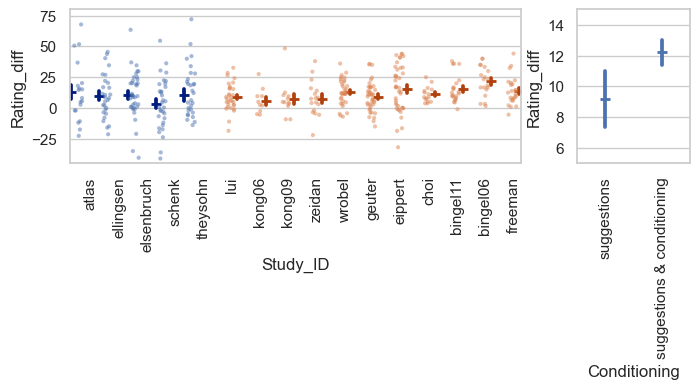

In [28]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(8, 2), gridspec_kw={'width_ratios': [4, 1]})
# Plot data with jitter and summary statistics
sns.stripplot(x='Study_ID', y='Rating_diff', hue='Conditioning', data=data.sort_values(by='Conditioning'), jitter=0.3, alpha=0.5, dodge=True, legend=False, ax=axes[0], size=3)
sns.pointplot(x='Study_ID', y='Rating_diff', hue='Conditioning', data=data.sort_values(by='Conditioning'), dodge=0.9, palette="dark", markers="_", errorbar="se", legend=False, linestyle='none', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='right', rotation_mode='anchor')
axes[0].set_ylim(-45, 80)

#sns.violinplot(x='Conditioning', y='Rating_diff', data=data, inner='quartile', ax=axes[1])
#sns.boxplot(x='Conditioning', y='Rating_diff', data=data, ax=axes[1])
sns.pointplot(x='Conditioning', y='Rating_diff', data=data, markers="_", errorbar="se", linestyle='none', ax=axes[1])

plt.axhline(0, color='gray', linestyle='dashed', alpha=0.5)
plt.xticks(rotation=90)
plt.ylim(5, 15)
#plt.legend(title='Conditioning')
plt.savefig('../fig/behav_pointplot.pdf')
plt.show()

## Plot the interaction between rating pain and rating difference

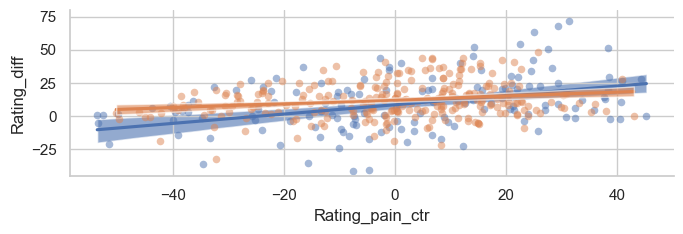

In [29]:
sns.set(style="whitegrid")

# Plot data with jitter and summary statistics
sns.lmplot(x='Rating_pain_ctr', y='Rating_diff', hue='Conditioning', data=data.sort_values(by='Conditioning'), 
           scatter_kws={'alpha':0.5, 's':30, 'linewidths': 0}, 
           line_kws={'alpha': 1},
           legend=False, height=2.5, aspect=2.8)
plt.setp(plt.gca().collections[1], alpha=0.6, zorder=-10)
plt.setp(plt.gca().collections[3], alpha=0.6, zorder=10)
plt.ylim(-45, 80)
plt.savefig('../fig/behav_interaction.pdf')

## Analysis of the placebo induction effect on the rating difference using Hedges G-values
Hedges' G may be a more robust measure of the effect size.

In [30]:
from scipy import stats

hedgesG = pd.read_csv('../data/behavior_hedgesG.txt', sep='\t')
hedgesG = hedgesG.merge(studies[['study_ID', 'placebo_induction']], left_on='studyID', right_on='study_ID', how='inner')

hedgesG['HedgesG'] = -1*hedgesG['HedgesG']
# Test the two groups in placebo induction against each other
group1 = hedgesG[hedgesG['placebo_induction'] == 'suggestions']['HedgesG']
group2 = hedgesG[hedgesG['placebo_induction'] == 'suggestions & conditioning']['HedgesG']

t_stat, p_value = stats.ttest_ind(group1, group2)
print(f'T-statistic: {t_stat}, p-value: {p_value}')
# Calculate degrees of freedom
df = len(group1) + len(group2) - 2
print(f'Degrees of freedom: {df}')

# Print means for each group
print("\nGroup means:")
print(f"Suggestions only (n={len(group1)}): {group1.mean():.3f} ± {group1.std():.3f}")
print(f"Suggestions & conditioning (n={len(group2)}): {group2.mean():.3f} ± {group2.std():.3f}")
print(f"Difference: {group2.mean() - group1.mean():.3f} ± {np.sqrt(group1.std()**2 + group2.std()**2):.3f}")

# Calculate percentage difference compared to suggestions only group
percent_diff = ((group2.mean() - group1.mean()) / abs(group1.mean())) * 100
print(f"\nPercentage difference compared to suggestions only group: {percent_diff:.1f}%")



hedgesG

T-statistic: -2.864632904187506, p-value: 0.01248424961254062
Degrees of freedom: 14

Group means:
Suggestions only (n=5): 0.367 ± 0.121
Suggestions & conditioning (n=11): 0.744 ± 0.278
Difference: 0.377 ± 0.303

Percentage difference compared to suggestions only group: 102.6%


,studyID,HedgesG,study_ID,placebo_induction
0,atlas,0.478998,atlas,suggestions
1,bingel06,1.045384,bingel06,suggestions & conditioning
2,bingel11,1.095937,bingel11,suggestions & conditioning
3,choi,0.806839,choi,suggestions & conditioning
4,eippert,0.666957,eippert,suggestions & conditioning
5,ellingsen,0.456696,ellingsen,suggestions
6,elsenbruch,0.374770,elsenbruch,suggestions
7,freeman,0.964804,freeman,suggestions & conditioning
8,geuter,0.695140,geuter,suggestions & conditioning
9,kong06,0.395444,kong06,suggestions & conditioning


### Plot the Hedges G-values by study

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_65973/1819742140.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='right', rotation_mode='anchor')
/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_65973/1819742140.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='placebo_induction', y='HedgesG', data=hedgesG, ax=axes[1], dodge=False, palette="dark", width=1, alpha=0)
/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_65973/1819742140.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='placebo_ind

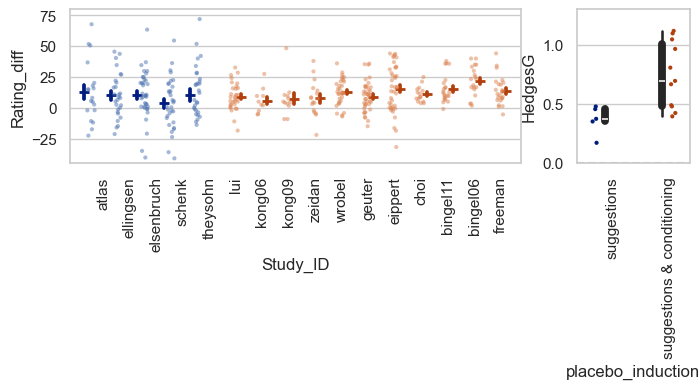

In [31]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(8, 2), gridspec_kw={'width_ratios': [4, 1]})
# Plot data with jitter and summary statistics
sns.stripplot(x='Study_ID', y='Rating_diff', hue='Conditioning', data=data.sort_values(by='Conditioning'), jitter=0.3, alpha=0.5, dodge=True, legend=False, ax=axes[0], size=3)
sns.pointplot(x='Study_ID', y='Rating_diff', hue='Conditioning', data=data.sort_values(by='Conditioning'), dodge=0.9, palette="dark", markers="_", errorbar="se", legend=False, linestyle='none', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='right', rotation_mode='anchor')
axes[0].set_ylim(-45, 80)
axes[0].set_xlim(-1, 16)

# Plot Hedges G-values separately for each study, grouped into study groups
sns.violinplot(x='placebo_induction', y='HedgesG', data=hedgesG, ax=axes[1], dodge=False, palette="dark", width=1, alpha=0)
sns.stripplot(x='placebo_induction', y='HedgesG', data=hedgesG, jitter=0.1, alpha=1, dodge=True, ax=axes[1], size=3, palette="dark")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha='right', rotation_mode='anchor')
axes[1].set_ylim(0, 1.3)
axes[1].set_xlim(-0.5, 1.5)
plt.axhline(0, color='gray', linestyle='dashed', alpha=0.5)
plt.xticks(rotation=90)
#plt.ylim(-1.5, 0.5)
#plt.legend(title='Conditioning')
#plt.tight_layout()
plt.savefig('../fig/behav_pointplot_hedgesG.pdf')
plt.show()

### Analysis of the Hedges G-values using a linear model

In [32]:
model = smf.ols(formula='Rating_diff ~ plc_induction + Rating_pain_ctr + Age + Male' + ' + ' + ' + '.join(colnames),
                data=design).fit()

model_restricted = smf.ols(formula='Rating_diff ~ plc_induction + Rating_pain_ctr + Age + Male',
                data=design).fit()

f, p, df = model.compare_f_test(model_restricted)
print(f'F-statistic: {f}, p-value: {p}, df: {df}')

F-statistic: 2.4368272671859095, p-value: 0.0026929251450258924, df: 14.0
